In [31]:
import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

BATCH_SIZE = 128

device = torch.device("mps")

In [32]:
norm_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

datasets = utils.data.Datasets(
    "/Users/henrywilliams/Documents/uni/amml/assessment/data", transform=norm_transform
)

X = torch.tensor(datasets.n6_full().numpy().reshape(-1, 1, 36, 36))
mu, std = X.mean(), X.std()

norm_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
        v2.Lambda(lambda x: x.repeat(3, 1, 1)),
        v2.Normalize((mu,), (std,)),
    ]
)

datasets = utils.data.Datasets(
    "/Users/henrywilliams/Documents/uni/amml/assessment/data", transform=norm_transform
)
X = torch.tensor(
    datasets.n6_full(image_shape=(3, 224, 224)).numpy().reshape(-1, 3, 224, 224)
)
# mu, std = X.mean(), X.std()
# print(mu, std)

# assert torch.isclose(
#     mu, torch.tensor(0.0, dtype=torch.double)
# ), "mean should be nearly zero"
# assert torch.isclose(
#     std, torch.tensor(1.0, dtype=torch.double)
# ), "std should be nearly one"

y = torch.arange(0, 16).repeat(400)
print(X.shape, y.shape)
data = TensorDataset(X, y)
train, test = train_test_split(data, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

torch.Size([6400, 3, 224, 224])
torch.Size([6400])

In [ ]:
from torchvision import models

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 16), nn.Softmax(dim=1)
)

model(
    torch.randn(
        1,
        3,
        224,
        224,
    )
)

tensor([[0.0645, 0.0736, 0.0612, 0.0659, 0.0641, 0.0593, 0.0594, 0.0608, 0.0671,
         0.0555, 0.0625, 0.0566, 0.0650, 0.0564, 0.0643, 0.0637]],
       grad_fn=<SoftmaxBackward0>)

In [29]:
def test(model, data):
    model.eval()

    test_losses = []
    test_loop = tqdm(
        data,
        desc="Testing",
        leave=False,
        unit="batch",
    )
    for img, label in test_loop:
        img = img.to(torch.float32).to(device)
        label = label.to(device)

        with torch.no_grad():
            pred = model(img)

        loss = loss_fn(pred, label)
        test_losses.append(loss.cpu())
        test_loop.set_postfix_str(f"Loss: {np.mean(test_losses)}")

    model.train()
    return np.mean(test_losses)


EPOCHS = 50
test_losses = []
train_losses = []
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    test_losses.append(test(model, test_loader))
    train_loop = tqdm(
        train_loader,
        desc=f"Train epoch {epoch + 1}/{EPOCHS}",
        leave=False,
        unit="batch",
        postfix=f"Test Loss: {test_losses[-1]:.2f}",
    )

    for img, label in train_loop:
        img = img.to(torch.float32).to(device)
        label = label.to(torch.float32).to(device)

        pred = model(img)

        optim.zero_grad()
        loss = loss_fn(pred, label)

        loss.backward()
        optim.step()
        train_losses.append(loss.cpu().detach().item())


KeyboardInterrupt: 

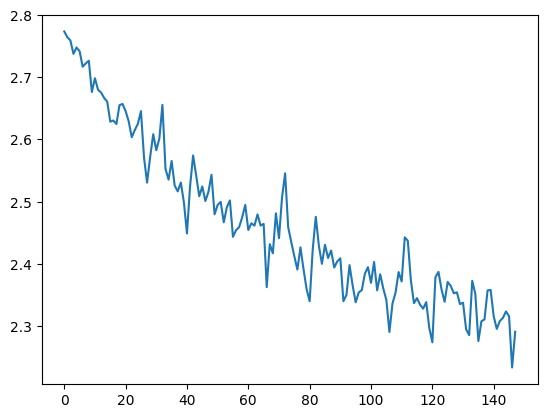

In [21]:
plt.plot(train_losses)